![](Scanpy_logo.svg){width=50% fig-align="center"}

# 데이터 품질 관리의 목적

scRNA-seq 데이터에는 두 가지 중요한 특성이 있습니다. 첫째, scRNA-seq 데이터는 드롭아웃이 발생하는데, 이는 mRNA으로 인해 데이터에 0이 과도하게 많다는 것을 의미합니다. 둘째, 생물학적 복잡성으로 인해 얻은 데이터를 보정하고 품질 관리에 제한이 존재합니다. 따라서 생물학적 의미를 과하게 보정하거나 제거하지 않으면서 적합한 전처리 방법을 선택하는 것이 중요합니다. 예를 들어, 품질 관리 중에 너무 많은 세포를 걸러내면 희귀한 세포 집단을 놓칠 수 있습니다. 반대로 품질이 좋지 않은 세포를 제외하지 않으면 세포에 주석을 달기가 어려울 수 있습니다. 이 문서에서는 이러한 위험을 제거하고 고품질 데이터를 얻는 방법과 결과에 대해 설명합니다.

In [1]:
# | echo: false
import warnings

warnings.filterwarnings("ignore")
# warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
    figsize=(6, 5),
)

# 사용한 가상 환경
# mamba activate scanpy

# 카운트 행렬 데이터 불러오기

시작점은 `cellranger`를 통해 얻은 카운트 행렬(count matrix) 데이터 입니다. 카운트 행렬은 분자 식별자(UMI)로 구별된 바코드 X 각 유전자의 수로 구성된 표입니다. 

> 분자 식별자가 잘못 붙어 있을 수도 있음으로 세포라는 용어 대신에 바코드라는 용어를 사용합니다.

In [2]:
# load data
data_path = "../input/231114_HL187/Isotype/"
sample_name = "Isotype"

adata = sc.read_10x_h5(data_path + "filtered_feature_bc_matrix.h5")
# 일부 변수(=유전자)가 두 번 이상 나타나서 다운스트림 분석 작업에서 오류나 의도하지 않은 동작을 일으킬 수 있음으로
# 중복되는 요소에 숫자(예: '1', '2' 등)를 추가하여 변수 이름을 고유하게 만듭니다.
adata.var_names_make_unique()
# print(f"데이터 세트의 형태는 n_obs {adata.shape[0]} x n_vars {adata.shape[1]} 입니다.")
init_barcode_count = adata.shape[0]
init_gene_count = adata.shape[1]
adata

AnnData object with n_obs × n_vars = 13486 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

정상적으로 데이터가 불러져 왔다면 `adata.var`에서 `gene_ids(Ensembl Id)`, `feature_types` 등의 유전자 정보와 바코드(`n_obs`) X 유전자 수(`n_vars`)를 확인 할 수 있습니다.


# 저품질 시퀀싱 데이터 제거


첫 번째 단계는 데이터셋에서 품질이 낮은 판독값을 제거하는 것입니다. 예를 들어 검출된 유전자 수가 적고 미토콘드리아 유전자 비율이 높은 경우, 세포막이 손상되 죽어가는 세포일 가능성이 높습니다. 이런 세포는 분석 대상이 아니며 다운스트림 분석을 왜곡할 수 있으므로 제거합니다. 이런 세포를 식별하기 위해서는 일반적으로 다음 세 가지 항목(QC metric)을 사용합니다.


- 바코드당 카운트 수(카운트 깊이)
- 바코드당 유전자 수
- 바코드당 미토콘드리아 유전자 비율

저품질 데이터는 각 항목의 임계값을 통해 필터링되며 낮은 카운트 깊이와 검출된 유전자 수, 높은 비율의 미토콘드리아 유전자로 판단합니다. 세포 신호가 잘못 해석될 수 있으므로 임계값을 결정할 때는 여러 변인을 고려해야 합니다. 예를 들어 미토콘드리아 수가 상대적으로 높은 세포는 호흡 과정에 관여할 수 있으므로 필터링해서는 안 됩니다. 반면, 미토콘드리아 수가 낮거나 높은 세포는 휴지기에 있는 세포 집단이나 크기가 큰 세포에 해당할 수 있습니다. 따라서 일반적으로 가능한 적은 수의 세포를 제외하고 최대한 허용하는 것이 좋습니다.

여기에서는 MAD(중앙값 절대 편차)를 사용한 임계값 설정으로 저품질 데이터를 필터링 합니다. MAD는 $MAD=median(|X_i-median(X)|)$ 로 주어지며, $X_i$ 는 관측값의 각 QC 메트릭이며 메트릭의 변동성을 나타냅니다. Germain et al., 2020에서 사용된 것 처럼 5 MAD 차이가 나는 경우에 이상값으로 표시하겠습니다. `scanpy`에서는 `sc.pp.calculate_qc_metrics` 함수를 사용해 `QC metric` 계산 할 수 있습니다. 다음의 코드를 사용해 미토콘드리아, 리보솜 및 헤모글로빈 유전자를 정의합니다. 미토콘드리아 유전자는 종에 따라 접두사 `mt-`(마우스) 또는 `MT-`(사람)이 추가되어 있습니다.

In [3]:
# for mouse genes
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith("Rpl")
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")
# Malat1
adata.var["Malat1"] = adata.var_names.str.contains("Malat1")

# calculate the respective QC metrics with scanpy.
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo", "hb", "Malat1"],
    inplace=True,
    percent_top=[20],
    log1p=True,
)

adata

AnnData object with n_obs × n_vars = 13486 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_Malat1', 'log1p_total_counts_Malat1', 'pct_counts_Malat1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'Malat1', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
df = pd.concat(
    [
        adata.obs.n_genes_by_counts.describe(),
        adata.obs.total_counts.describe(),
        adata.obs.pct_counts_mt.describe(),
        adata.obs.pct_counts_ribo.describe(),
        adata.obs.pct_counts_hb.describe(),
    ],
    axis=1,
)

df

,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo,pct_counts_hb
count,13486.000000,13486.000000,13486.000000,13486.000000,13486.000000
mean,2170.148228,7194.561523,1.063374,8.822847,0.008010
std,1066.073444,5309.599609,1.890632,3.806559,0.022218
min,180.000000,500.000000,0.000000,0.200000,0.000000
25%,1334.000000,2991.250000,0.499700,6.600059,0.000000
50%,2122.000000,6181.500000,0.764679,8.779517,0.000000
75%,2874.000000,10178.750000,1.127175,10.907173,0.007614
max,8886.000000,79911.000000,55.456173,35.833851,0.730536


출력 결과를 통해 `.var`와 `.obs`에 몇 개의 열이 추가되었습니다. 추가된 열에 대한 간략한 설명은 아래와 같으며 자세한 내용은 `scanpy` 공식 문서에서 확인할 수 있습니다.

- `.obs`의 `n_genes_by_counts`는 셀에서 양수인 유전자의 수입니다,
- `total_counts`는 셀의 총 카운트 수이며, 라이브러리 크기로도 알려져 있습니다.
- `pct_counts_mt`는 세포의 총 개수 중 미토콘드리아 유전자의 비율입니다. 죽어가는 세포는 발현이 더 높은 것으로 관찰되었습니다.
- `Malat1` poly-A로 캡처한 RNA-seq 데이터에서 자주 검출되며 주로 기술적 편향인 경우가 많습니다.
- `pct_counts_ribo`는 세포의 총 개수 중 리보솜 유전자의 비율로 세포 유형을 판단하는데 별 도움이 되지 않는다고 알려졌습니다.

이제 몇 가지 QC metric에 대한 시각화를 해봅니다.

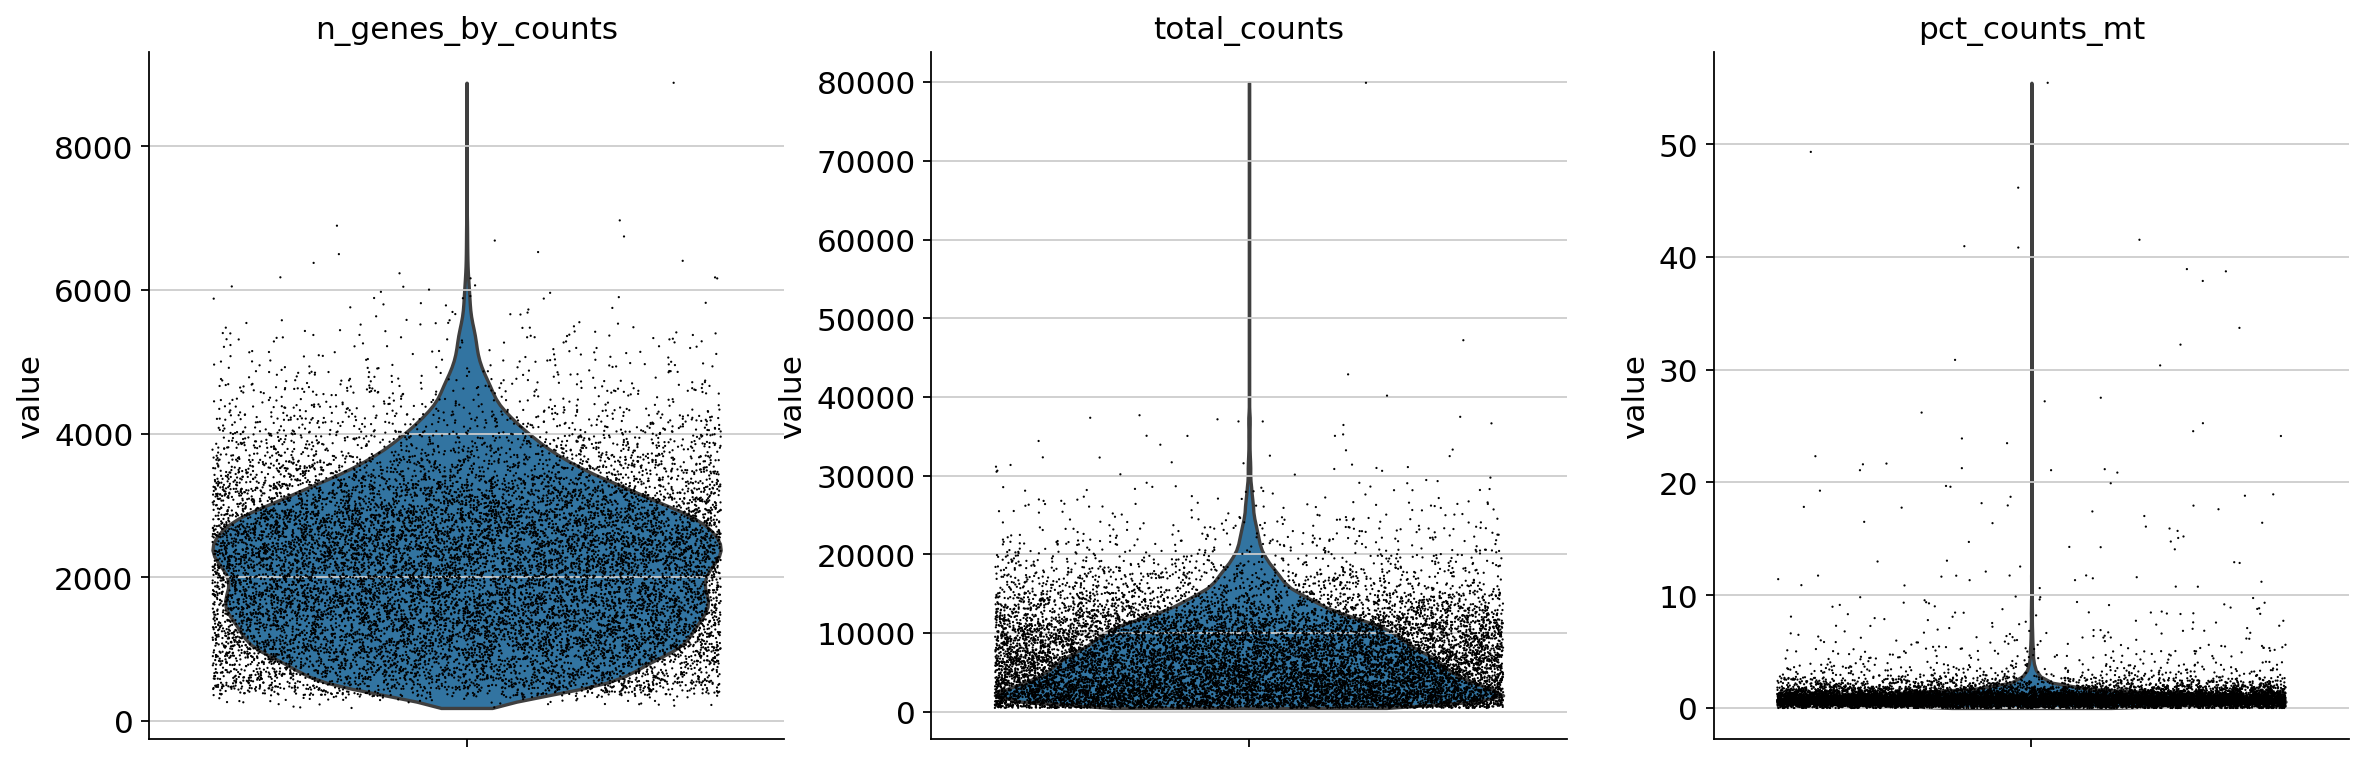

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

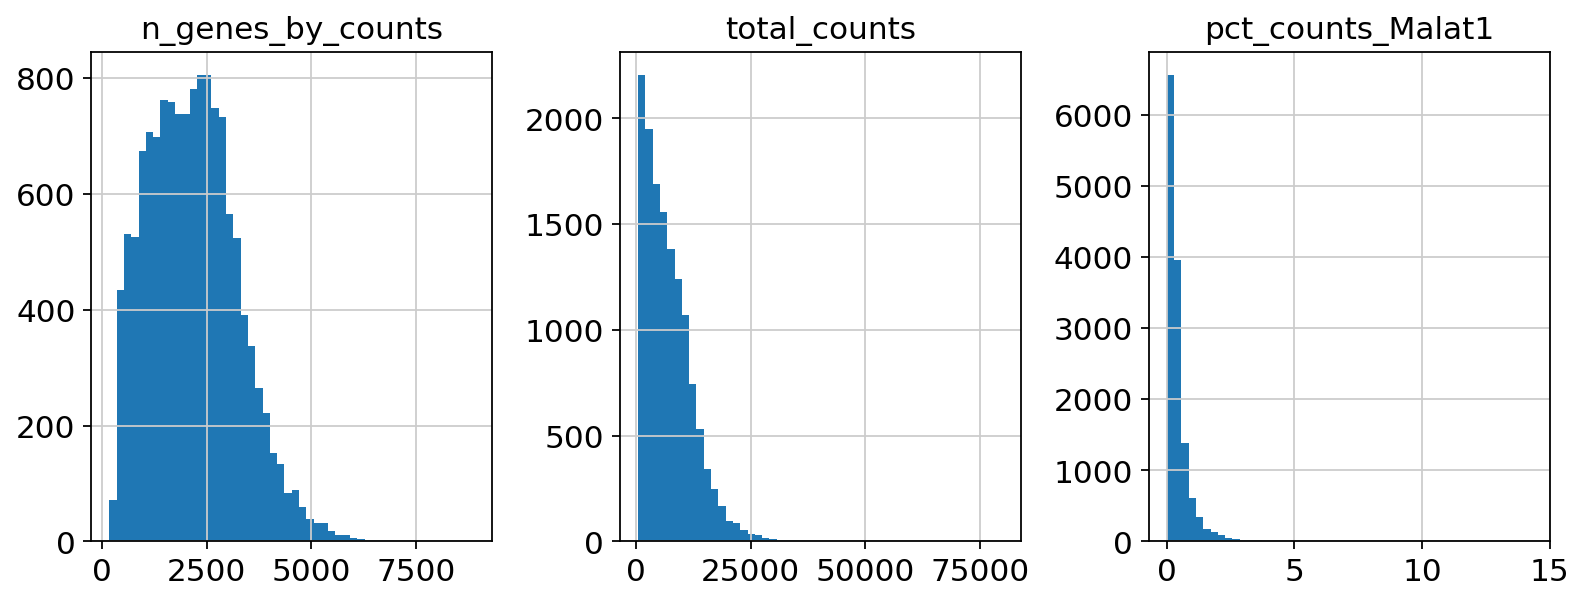

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax[0].hist(adata.obs.n_genes_by_counts, bins=50)
ax[0].set_title("n_genes_by_counts")
ax[1].hist(adata.obs.total_counts, bins=50)
ax[1].set_title("total_counts")
ax[2].hist(adata.obs.pct_counts_Malat1, bins=50)
ax[2].set_title("pct_counts_Malat1")

plt.tight_layout()
plt.show()

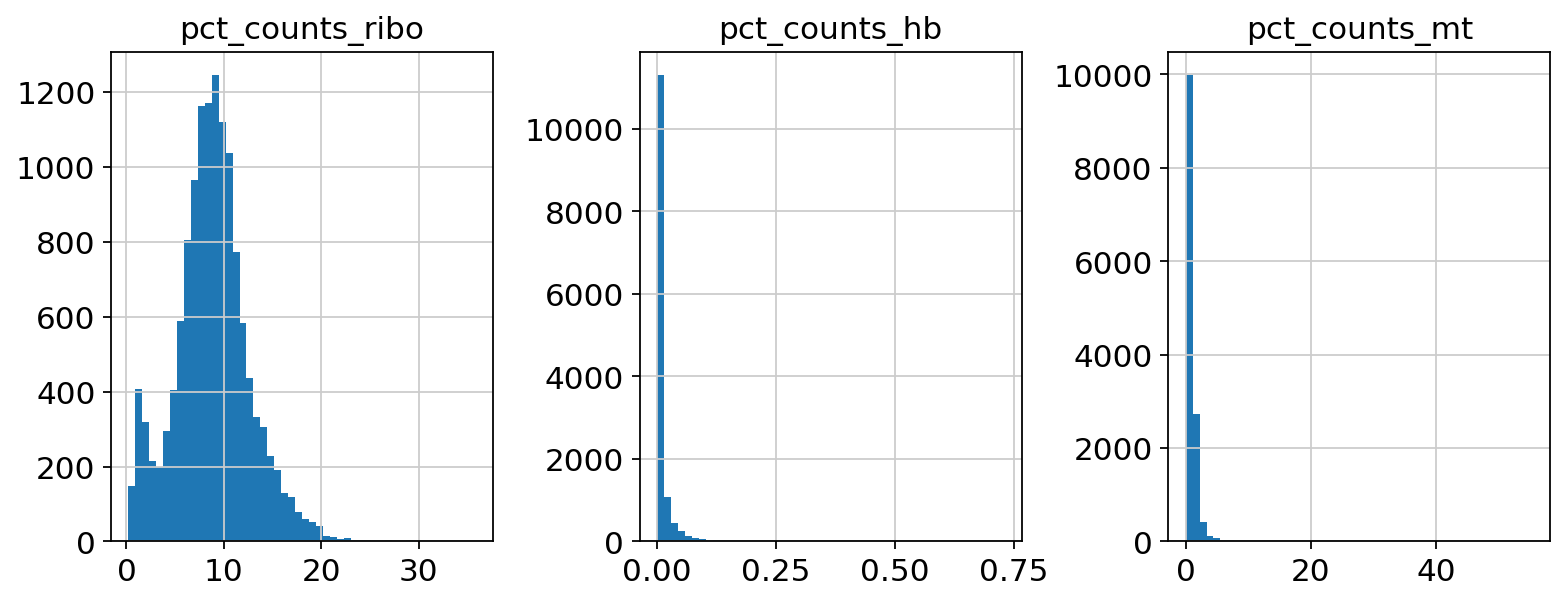

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax[0].hist(adata.obs.pct_counts_ribo, bins=50)
ax[0].set_title("pct_counts_ribo")
ax[1].hist(adata.obs.pct_counts_hb, bins=50)
ax[1].set_title("pct_counts_hb")
ax[2].hist(adata.obs.pct_counts_mt, bins=50)
ax[2].set_title("pct_counts_mt")

plt.tight_layout()
plt.show()

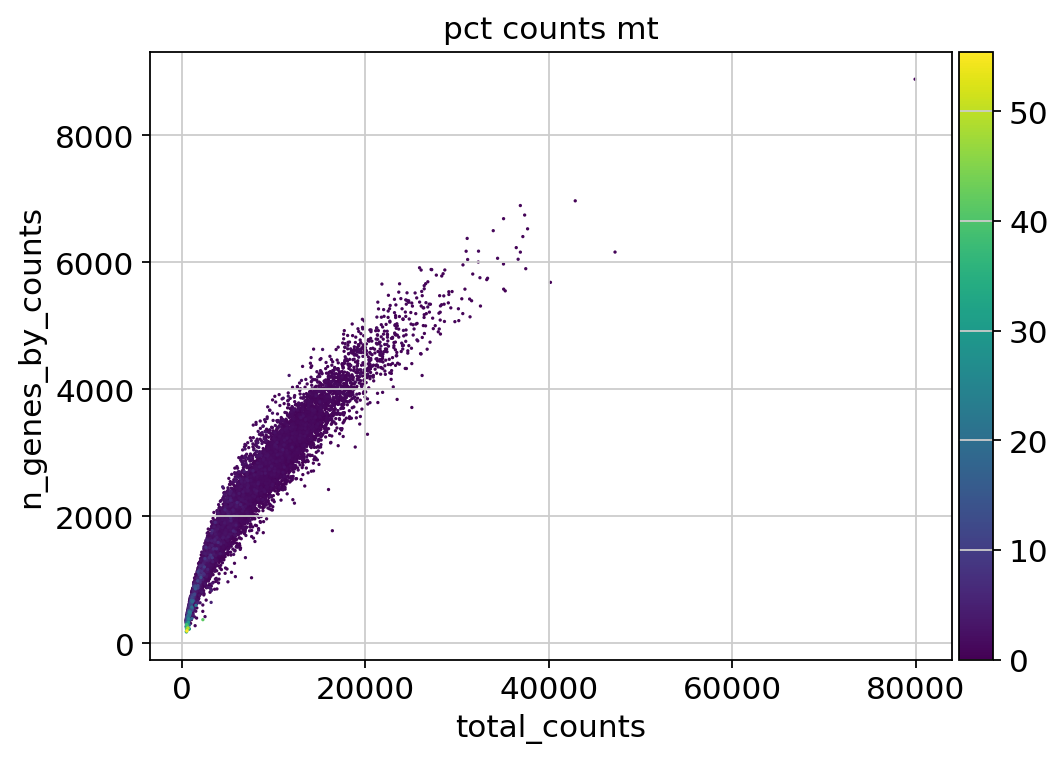

In [8]:
# | layout-ncol: 2
sc.pl.scatter(
    adata,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
)
plt.show()

위 플롯을 통해 미토콘드리아 유전자의 비율이 높으면 셀의 총 카운트 수(total_counts)와 유전자의 수(n_genes_by_counts)가 매우 높다는 것을 알 수 있습니다. 이 플롯을 기반으로 MAD을 통한 필터링을 적용하겠습니다. 먼저, 아래와 같이 MAD 함수를 정의하고 `log1p_total_counts`, `log1p_n_genes_by_counts`, `pct_counts_in_top_20_genes` QC metric으로 5 MAD 사이의 데이터를 필터링 합니다.

In [9]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    13155
True       331
Name: count, dtype: int64

미토콘드리아 유전자 비율은 좀 더 엄격하게 3 MAD 기준으로 필터링하고 백분율이 8%를 초과하는 세포도 제외합니다.

In [11]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    12054
True      1432
Name: count, dtype: int64

이제 `outlier`, `mt_outlier` 에 모두 해당하는 데이터는 제거하고 미토콘드리아 유전자의 비율에 대해 시각화합니다. 시각화를 통하면 직관적으로 알수 있습니다.

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 13486
Number of cells after filtering of low quality cells: 11826


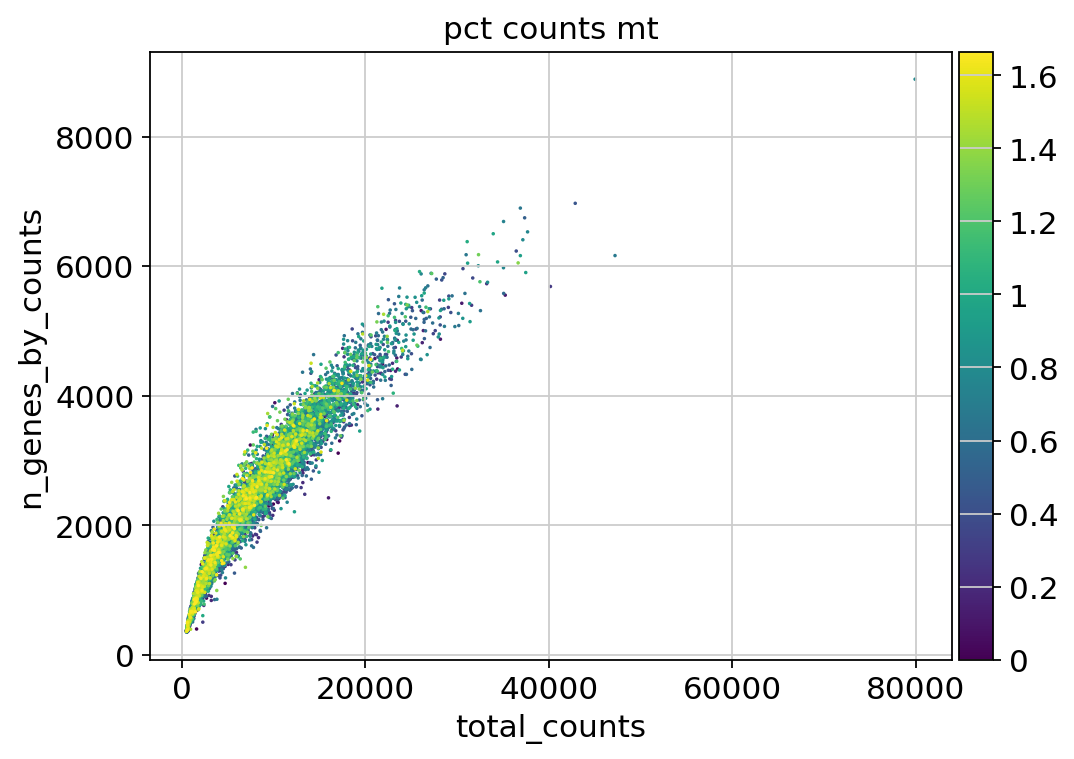

In [13]:
# | layout-ncol: 2
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
plt.show()

## 배경(Ambient) RNA 제거


![배경 RNA는 세포의 기본 mRNA와 함께 카운트되어 혼동을 일으킵니다.](https://www.sc-best-practices.org/_images/ambient_rna.jpeg)

`droplet` 기술을 사용한 scRNA-seq의 경우, 세포가 용해되면서 나온 mRNA가 세포들과 함께 시퀀싱될 수 있습니다. 이런 현상을 배경(Ambient) RNA 오염이라 하며 다운스트림 분석에서 해석을 왜곡할 수 있습니다.

배경 RNA 오염은 사용한 scRNA-seq 기술과 분석한 세포의 유형에 따라 달라지기 때문에 데이터를 적절하게 보정하는 것이 중요합니다. 현재 알려진 방법으로는 `SoupX`[Young and Behjati, 2020] 및 `DecontX`[Yang et al., 2020]와 같은 방법이 있는데 이는 세포 용해액의 구성을 추정해 카운트 행렬의 값을 수정하는 원리입니다. 

`SoupX`는 `R`언어로 작성되어 있음으로 아래의 코드와 같이 파이썬의 `rpy2` 모듈을 사용해야 합니다.

In [14]:
# | echo: false
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [15]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

`SoupX`로 더 나은 결과를 얻기 위해서는 클러스터링 정보가 필요합니다.[Young and Behjati, 2020] 먼저 `AnnData` 객체의 복사본을 만들어 정규화하고, 클러스터링을 진행 합니다. 클러스터링 정보는 `soupx_groups` 객체로 저장해 사용합니다.

In [16]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# 클러스터를 .obs에 soupx_groups로 추가하고 벡터로 저장합니다.
soupx_groups = adata_pp.obs["soupx_groups"]

# AnnData 객체의 복사본을 삭제해 메모리를 절약합니다.
del adata_pp

# 세포, 유전자, 필터링된 카운터 행렬을 저장합니다.
# SoupX에는 모양 특징 x 바코드 행렬이 필요하므로 transpose해야 합니다.
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

`cellranger`에서 얻은 `raw_feature_bc_matrix.h5`를 `data_tod` 객체로 저장해 `SoupX`의 인풋으로 사용합니다.

In [17]:
adata_raw = sc.read_10x_h5(
    filename=data_path + "raw_feature_bc_matrix.h5",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
# 객체를 삭제해 메모리를 절약합니다.
del adata_raw

이제 `SoupX`를 실행하기 위한 모든 준비가 완료되었습니다. `SoupChannel` 객체를 만들고 메타데이터를 데이터 프레임 형식으로 추가합니다. 그런다음 `autoEstCont`함수를 사용해 배경 RNA 오염 비율을 계산하고 `adjustCounts`로 카운트 행렬을 보정합니다.다

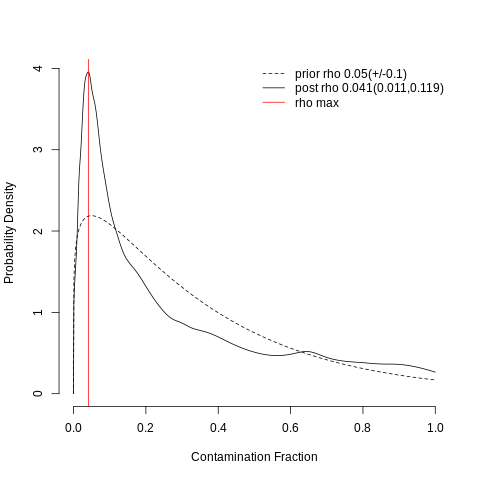

In [18]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=TRUE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

이후의 모든 분석 단계에 보정된 카운트 행렬을 사용하고자 `soupX_counts` 레이어로 `.X`을 덮어씌웁니다.

In [19]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

추가로 최소 20개 이상의 세포에서 검출되지 않는 유전자는 필터링합니다.

In [20]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 32285
Number of genes after cell filter: 14534


## 이중체(Doublet) 검출

![세포 쌍을 무작위로 샘플링하고 유전자 발현 프로필을 평균화하여 염색체 수를 얻고 PCA 공간에 투영합니다. 그런 다음 kNN으로 Doublet점수를 계산해 검출합니다.](https://www.sc-best-practices.org/_images/doublet_detection.jpeg)

이중체는 두 개 이상의 세포가 하나의 `droplet`에 포함된 것입니다. 이런 기술적인 문제가 있기 때문에 카운터 행렬에서 '세포' 대신 '바코드'라는 용어를 사용하는 것입니다. 이중체는 동일한 세포 유형(그러나 다른 개체에서 유래한)에 의해 형성된 동형 이중체와 그렇지 않은 이형 이중체가 있습니다. 동형 이중체는 카운트 행렬의 정보로 구별이 어렵고 셀 해싱이나 SNP로만 식별할 수 있기 때문에 여기서 다루는 이중체 검출의 목표가 아닙니다.

반면에 이형 이중체는 잘못 분류될 가능성이 높고 다운스트림  결과를 왜곡할 수 있음으로 이를 식별하는 것은 중요합니다. 일반적으로 이중체 검출은 전처리 초기 단계에서 진행합니다. 이형 이중체 검출을 위한 여러 소프트웨어 패키지들이 있는데 `scDblFinder`는 현재 가장 검출 정확도가 높고 우수한 계산 효율성 및 안정성을 가진 도구로 평가됩니다.[Xi and Li, 2021] 따라서 여기에서는 `scDblFinder` 사용합니다.

In [21]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [22]:
data_mat = adata.X.T

`scDblFinder`는 입력 값으로 `SingleCellExperiment`객체를 사용하므로 아래 예시 코드와 같이 `AnnData`객체를 변환해야 합니다.
코드를 실행하면 다음의 열이 결과로 추가됩니다. 

- scDblFinder.score: Doublet 점수(높을수록 셀이 이중일 가능성이 높음)
- scDblFinder.class: 분류(Doublet 또는 Singlet)

In [23]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(42)
sce = scDblFinder(
    SingleCellExperiment(list(counts=data_mat), )
)

doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [24]:
# scDblFinder 결과를 AnnData 객체의 .obs에 추가합니다.
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    10125
doublet     1701
Name: count, dtype: int64

Doublet 점수를 시각화해 `scDblFinder_class`이 올바른지 확인합니다.

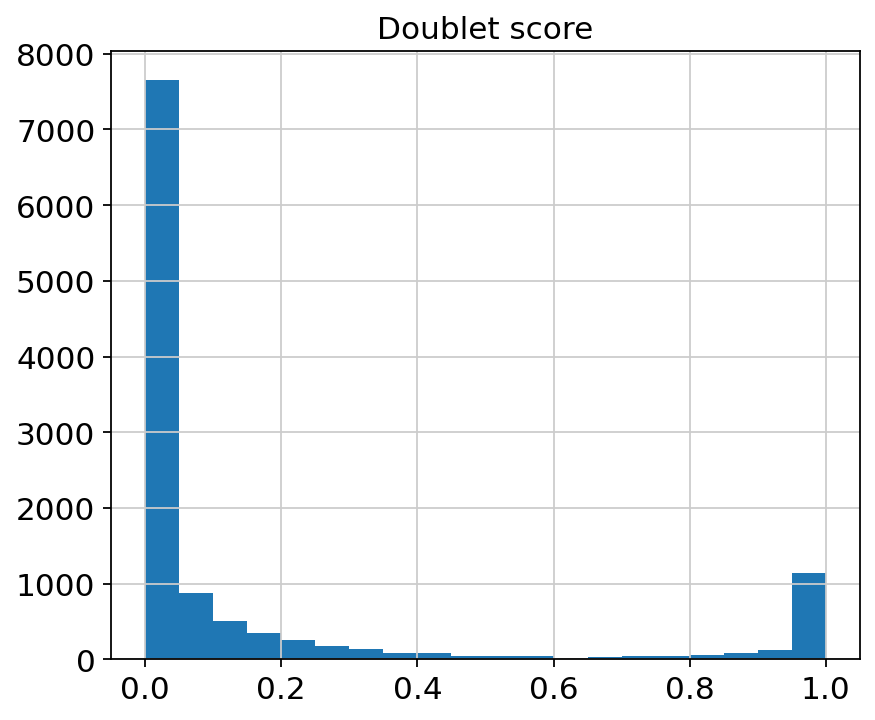

In [25]:
# | layout-ncol: 2
plt.hist(doublet_score, bins=20)
plt.title("Doublet score")
plt.show()

추후에 진행될 다운스트림 분석 과정에서 더 많은 또는 더 적은 셀을 필터링하는 것이 필요할 수 있습니다. 따라서 지금 당장 식별된 이중체를 삭제하는 것은 좋은 생각이 아닙니다.
지금까지 진행한 품질 관리 절차를 통해 얼마나 많은 바코드와 유전자가 필터링 되었는지 확인하고 파일로 저장하겠습니다.

In [26]:
# | echo: false
# temp = adata.obs.scDblFinder_score < 0.98
# temp.value_counts()
# Doublet 제거는 나중에 해야한다.
# Remove doublelet
# adata = adata[adata.obs.scDblFinder_score < 0.98].copy()
pp_barcode_count = adata.shape[0]
pp_gene_count = adata.shape[1]
barcode_filter_ratio = round(pp_barcode_count / init_barcode_count, 1)
gene_filter_ratio = round(pp_gene_count / init_gene_count, 1)

print(f"바코드 수: {init_barcode_count} -> {pp_barcode_count}({barcode_filter_ratio})")
print(f"유전자 수: {init_gene_count} -> {pp_gene_count}({gene_filter_ratio})")
adata.write(f"../output/231114_{sample_name}.h5ad", compression="gzip")

바코드 수: 13486 -> 11826(0.9)
유전자 수: 32285 -> 14534(0.5)


# 결론

- 품질이 낮은 셀을 필터링할 때는 작은 하위 세포 집단이 사라지는 것을 피하기 위해 컷오프가 느슨한 MAD를 사용합니다.
- 유전자 기반 필터링은 다운스트림 분석 작업에 아무런 이점이 없습니다.
- 이형 이중체 검출은 `scDblFinder`와 같은 도구를 사용하여 효율적으로 감지할 수 있습니다.
- 여러 배치를 포함한 scRNA-seq 데이터에는 이형 이중체 검출법을 사용하면 안 됩니다.

# 참고 자료

- https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html
- https://academic.oup.com/gigascience/article/9/12/giaa151/6049831
- https://blog.naver.com/naturelove87/221474142816
- Pierre-Luc Germain, Anthony Sonrel, and Mark D. Robinson. pipeComp, a general framework for the evaluation of computational pipelines, reveals performant single cell rna-seq preprocessing tools. Genome Biology, 21(1):227, September 2020. doi:10.1186/s13059 020-02136-7.
- Malte D Luecken, et al. A sandbox for prediction and integration of dna, rna, and proteins in single cells. In Thirty-fifth Conference on Neural Information Processing Systems Datasets and Benchmarks Track (Round 2). 2021.
- Nan Miles Xi and Jingyi Jessica Li. Benchmarking Computational Doublet-Detection Methods for Single-Cell term RNA  Sequencing Data. Cell Systems, 12(2):176–194.e6, 2021. doi:https://doi.org/10.1016/j.cels.2020.11.008.
- Nan Miles Xi and Jingyi Jessica Li. Protocol for executing and benchmarking eight computational doublet-detection methods in single-cell RNA sequencing data analysis. STAR Protocols, 2(3):100699, sep 2021. doi:10.1016/j.xpro.2021.100699.
- Shiyi Yang, Sean E. Corbett, Yusuke Koga, Zhe Wang, W Evan Johnson, Masanao Yajima, and Joshua D. Campbell. Decontamination of ambient rna in single-cell rna-seq with DecontX. Genome Biology, 21(1):57, March 2020. doi:10.1186/s13059-020-1950-6.
- Matthew D Young and Sam Behjati. SoupX removes ambient term RNA contamination from droplet-based single-cell sequencing data. GigaScience, December 2020. doi:10.1093/gigascience/giaa151.
- Luke Zappia and Fabian J. Theis. Over 1000 tools reveal trends in the single-cell rna-seq analysis landscape. Genome Biology, 22(1):301, Oct 2021. doi:10.1186/s13059-021-02519-4.